In [ ]:
# Importing modules

import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')


In [ ]:
DATA_URL = "~/.lewagon/mlops/data/raw/train_100k.csv"
df = pd.read_csv(DATA_URL)

In [ ]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2013-03-27 19:55:37.0000004,10.00,2013-03-27 19:55:37 UTC,-73.986465,40.767152,-73.956891,40.768319,1
1,2014-01-07 15:39:00.00000062,260.22,2014-01-07 15:39:00 UTC,0.000000,0.000000,0.000000,0.000000,1
2,2010-03-07 15:57:05.0000001,13.30,2010-03-07 15:57:05 UTC,-73.995622,40.730620,-73.977744,40.776106,4
3,2009-04-27 10:46:00.00000096,8.10,2009-04-27 10:46:00 UTC,-73.957890,40.761478,-73.976955,40.754790,1
4,2009-08-30 03:02:00.00000027,8.90,2009-08-30 03:02:00 UTC,-73.967062,40.756738,-73.987007,40.722030,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  99999 non-null   float64
 6   dropoff_latitude   99999 non-null   float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


In [ ]:
# Compressing dtypes

def compress(df, **kwargs):
    """
    Reduces size of dataframe by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')
    
    in_size = df.memory_usage(index=True).sum()
    for t in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=t))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100
    
    print("optimized size by {} %".format(round(ratio,2)))
    print("new dataframe size: ", round(out_size / 1024**2,2), " MB")
    return df

In [ ]:
df = compress(df, verbose=True)
df.head(1)

old dataframe size:  6.1 MB
optimized size by 42.0 %
new dataframe size:  3.53  MB


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2013-03-27 19:55:37.0000004,10.0,2013-03-27 19:55:37 UTC,-73.986465,40.767151,-73.956894,40.768318,1


In [ ]:
df.dtypes

key                   object
fare_amount          float32
pickup_datetime       object
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count         int8
dtype: object

In [ ]:
# Compressing at import

DTYPES_RAW_OPTIMIZED = {
    "key": "O",
    "fare_amount": "float32",
    "pickup_datetime": "O",
    "pickup_longitude": "float32",
    "pickup_latitude": "float32",
    "dropoff_longitude": "float32",
    "dropoff_latitude": "float32",
    "passenger_count": "int8"
}

df = pd.read_csv(DATA_URL, dtype=DTYPES_RAW_OPTIMIZED)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float32
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float32
 4   pickup_latitude    100000 non-null  float32
 5   dropoff_longitude  99999 non-null   float32
 6   dropoff_latitude   99999 non-null   float32
 7   passenger_count    100000 non-null  int8   
dtypes: float32(5), int8(1), object(2)
memory usage: 3.5+ MB


In [ ]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,99999.000000,99999.000000,100000.000000
mean,11.312305,-72.525078,39.925163,-72.504692,39.919266,1.687630
std,30.004242,13.216076,9.318117,11.540226,9.251872,1.307139
min,-2.500000,-2217.368652,-74.016594,-964.573914,-74.027832,0.000000
25%,6.000000,-73.992149,40.734760,-73.991379,40.733757,1.000000
50%,8.500000,-73.981834,40.752541,-73.980194,40.753063,1.000000
75%,12.500000,-73.967194,40.767044,-73.963882,40.767971,2.000000
max,9000.410156,40.808010,1963.515869,40.828812,1963.515869,6.000000


In [ ]:
df.shape

(100000, 8)

In [ ]:
# removing redundant columns or rows
df = df.drop(columns=['key'])
df = df.drop_duplicates()
df.shape

(100000, 7)

In [ ]:
df = df.dropna(how='any', axis=0)
df.shape

(99999, 7)

In [ ]:
# removing buggy transactions
df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0) |
        (df.pickup_latitude != 0) | (df.pickup_longitude != 0)]
df = df[df.passenger_count > 0]
df = df[df.fare_amount > 0]

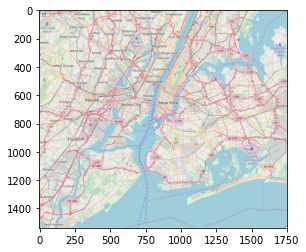

In [ ]:
# loading image of NYC map
bounding_boxes = (-74.3, -73.7, 40.5, 40.9)
url = 'https://wagon-public-datasets.s3.amazonaws.com/data-science-images/07-ML-OPS/nyc_-74.3_-73.7_40.5_40.9.png'
nyc_map = np.array(PIL.Image.open(urllib.request.urlopen(url)))
plt.imshow(nyc_map);

In [ ]:
df = df[df["pickup_latitude"].between(left=40.5, right=40.9)]
df = df[df["dropoff_latitude"].between(left=40.5, right=40.9)]
df = df[df["pickup_longitude"].between(left=-74.3, right=-73.7)]
df = df[df["dropoff_longitude"].between(left=-74.3, right=-73.7)]

In [ ]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97376.000000,97376.000000,97376.000000,97376.000000,97376.000000,97376.000000
mean,11.255835,-73.975586,40.750771,-73.974670,40.750957,1.693775
std,30.257261,0.034423,0.026905,0.033928,0.030579,1.304802
min,2.500000,-74.276474,40.503876,-74.276337,40.504002,1.000000
25%,6.000000,-73.992355,40.736468,-73.991570,40.735329,1.000000
50%,8.500000,-73.982124,40.753201,-73.980629,40.753746,1.000000
75%,12.500000,-73.968483,40.767460,-73.965614,40.768284,2.000000
max,9000.410156,-73.722946,40.889683,-73.702126,40.899448,6.000000


In [ ]:
# Removing extremes 
df = df[df.fare_amount < 400]
df = df[df.passenger_count < 8]

In [ ]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,10.0,2013-03-27 19:55:37 UTC,-73.986465,40.767151,-73.956894,40.768318,1
2,13.3,2010-03-07 15:57:05 UTC,-73.995621,40.730621,-73.977745,40.776108,4
3,8.1,2009-04-27 10:46:00 UTC,-73.957893,40.761478,-73.976952,40.754791,1
4,8.9,2009-08-30 03:02:00 UTC,-73.967064,40.756737,-73.987007,40.722031,1
5,21.0,2013-05-20 19:26:41 UTC,-73.999329,40.733829,-73.952194,40.699459,1
...,...,...,...,...,...,...,...
99995,12.0,2014-05-16 13:26:00 UTC,-73.992516,40.747742,-73.995255,40.724167,1
99996,11.0,2014-04-01 18:45:00 UTC,-73.981575,40.760326,-73.959396,40.771801,1
99997,6.9,2009-10-24 16:00:00 UTC,-73.902977,40.762909,-73.901184,40.766243,1
99998,6.5,2014-10-03 14:44:00 UTC,-73.975159,40.761032,-73.965820,40.763733,1


Text(0.5, 1.0, 'Histogram')

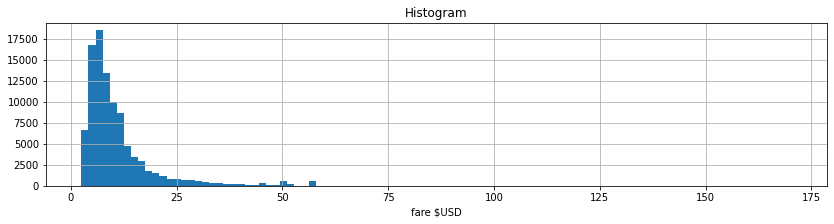

In [ ]:
df.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')

In [ ]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='red', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='blue', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

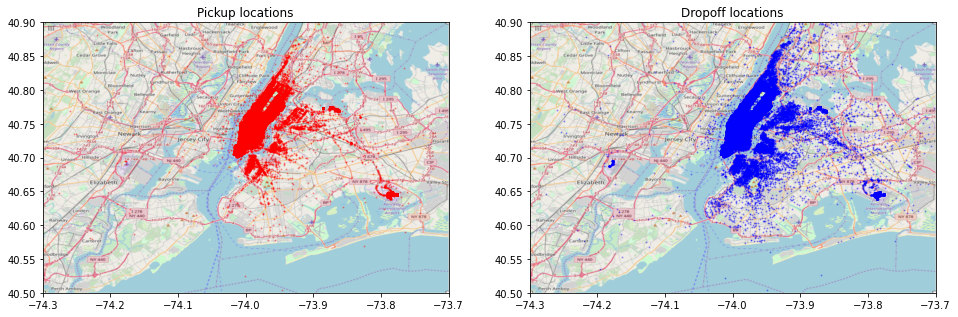

In [ ]:
plot_on_map(df, bounding_boxes, nyc_map, s=1, alpha=0.3)

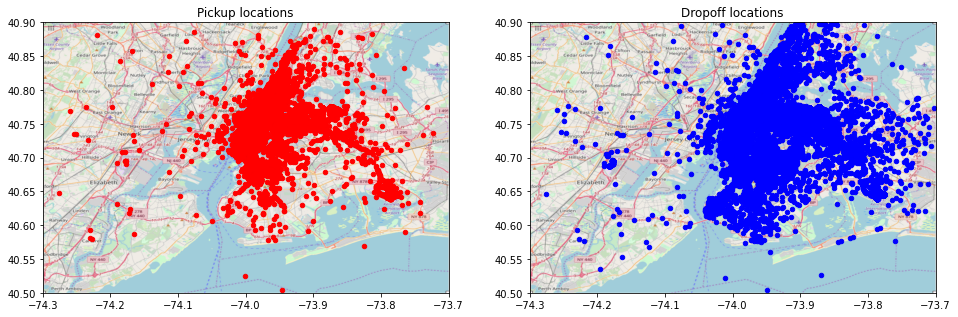

In [ ]:
plot_on_map(df, bounding_boxes, nyc_map, s=20, alpha=1.0)

In [ ]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    def select_within_boundingbox(df, BB):
        return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
            (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
            (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
            (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c="red", s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c="blue", s=0.01, alpha=0.5)

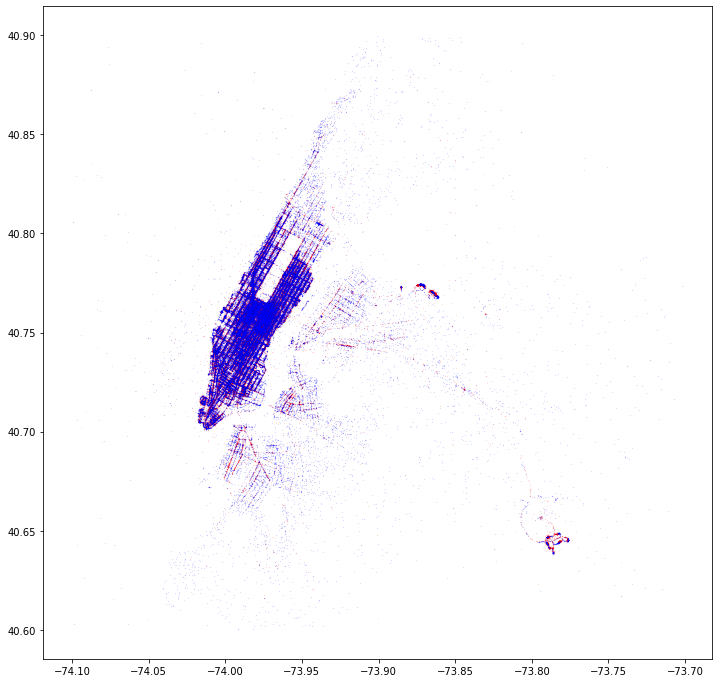

In [ ]:
plot_hires(df, (-74.1, -73.7, 40.6, 40.9))

In [ ]:
def manhattan_distance_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the haversine and manhattan distance between two points on the earth (specified in decimal degrees).
    Vectorized version for pandas df
    Computes distance in kms
    """
    earth_radius = 6371
    
    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])
    
    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad
    
    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius
    
    return manhattan_km

Text(0.5, 1.0, 'distance (km)')

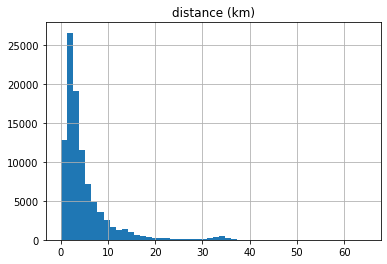

In [ ]:
df['distance'] = manhattan_distance_vectorized(df, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude")
df['distance'].hist(bins=50)
plt.title("distance (km)")

<AxesSubplot:xlabel='distance', ylabel='fare_amount'>

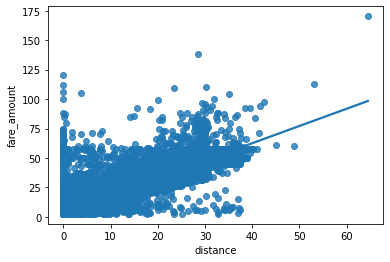

In [ ]:
sns.regplot(data=df, x='distance', y='fare_amount')

In [ ]:
# Calculating correlation
from scipy.stats import pearsonr
pearson, pvalue = pearsonr(df['distance'], df['fare_amount'])
print(f'{pearson=}')
print(f'{pvalue=}')

pearson=0.8680180370040489
pvalue=0.0


In [ ]:
# Baseline model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
mae = -1*cross_val_score(LinearRegression(), X=df[['distance']], y=df['fare_amount'], scoring='neg_mean_absolute_error').mean()
print(f'{mae=}')

mae=2.4835312366485596


In [ ]:
df = df.drop(columns=['distance'])
df.shape

(97375, 7)

In [ ]:
# Preprocessing 

X = df.drop("fare_amount", axis=1)
y = df[["fare_amount"]]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<AxesSubplot:xlabel='passenger_count', ylabel='Count'>

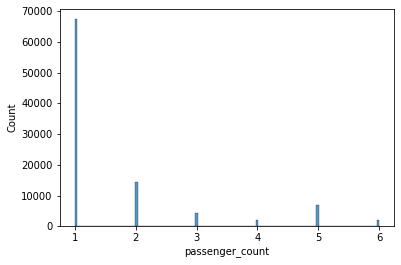

In [ ]:
sns.histplot(df.passenger_count)

In [ ]:
# passenger scaled pipeline
p_min = 1
p_max = 8
passenger_pipe = FunctionTransformer(lambda p: (p-p_min)/(p_max-p_min))

In [ ]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
    ],
)
preprocessor

ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x7f46a4b131f0>),
                                 ['passenger_count'])])

In [ ]:
preprocessor.fit_transform(X_train)

array([[0.        ],
       [0.        ],
       [0.71428571],
       ...,
       [0.        ],
       [0.        ],
       [0.14285714]])

First, let's extract category attributes from the "pickup_datetime"

In [ ]:
# Time factor preprocessing 

import math

def transform_time_features(X: pd.DataFrame)->np.ndarray:
    assert isinstance(X, pd.DataFrame)
    pickup_dt = pd.to_datetime(X["pickup_datetime"],
                                format="%Y-%m-%d %H:%M:%S UTC",
                                utc=True)
    pickup_dt = pickup_dt.dt.tz_convert("America/New_York").dt
    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month
    year = pickup_dt.year
    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)
    
    return np.stack([hour_sin, hour_cos, dow, month, year], axis=1)

X_time_processed = transform_time_features(X[["pickup_datetime"]])

pd.DataFrame(X_time_processed, columns=["hour_sin", "hour_cos", "dow", "month", "year"]).head()

,hour_sin,hour_cos,dow,month,year
0,-0.707107,-7.071068e-01,2.0,3.0,2013.0
1,0.500000,-8.660254e-01,6.0,3.0,2010.0
2,1.000000,6.123234e-17,0.0,4.0,2009.0
3,-0.258819,9.659258e-01,5.0,8.0,2009.0
4,-0.707107,-7.071068e-01,0.0,5.0,2013.0


In [ ]:
# One hot encoding days and months
time_categories = {
        0: np.arange(0, 7, 1),  # days of the week from 0 to 6
        1: np.arange(1, 13, 1)  # months of the year from 1 to 12
    }

OneHotEncoder(categories=time_categories, sparse=False)\
    .fit_transform(X_time_processed[:,[2,3]]) # [2,3] for ['dow', 'month'] !

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print(df.pickup_datetime.min())
print(df.pickup_datetime.max())

2009-01-01 00:38:27 UTC
2015-01-01 05:48:13 UTC


In [ ]:
year_min = 2009
year_max = 2019 # Our model may extend in the future

In [ ]:
time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse=False,
            handle_unknown="ignore"), [2,3]), # correspond to columns ["day of week", "month"], not the others columns
        (FunctionTransformer(lambda year: (year-year_min)/(year_max-year_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
        )
    )

preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
    ],
)
preprocessor

ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x7f46a4b131f0>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x7f46a4b139d0>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehotencoder',
                                                                                   OneHotEncoder(categories={0: array([0, 1, 2, 3, 4, 5, 6]),
                                                                                                             1: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])},
                                                                                                 handle_unknown='ignore',
                                                                                                 sparse=False),
                                                                                   [2,
                                                                                    3]),
                                                                                  ('functiontransformer',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x7f46c78051f0>),
                                                                                   [4])]))]),
                                 ['pickup_datetime'])])

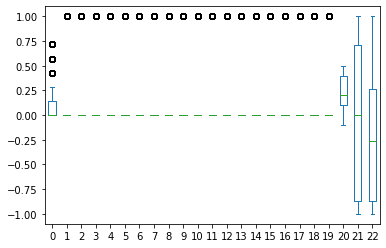

In [ ]:
pd.DataFrame(preprocessor.fit_transform(X_train)).plot(kind='box');

In [ ]:
# Distance processing

In [ ]:
lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

In [ ]:
def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the haverzine and manhattan distance between two points on the earth (specified in decimal degrees).
    Vectorized version for pandas df
    Computes distance in kms
    """
    earth_radius = 6371
    
    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])
    
    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad
    
    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius
    
    a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
    haversine_rad = 2 * np.arcsin(np.sqrt(a))
    haversine_km = haversine_rad * earth_radius
    
    return dict(
        haversize=haversine_km,
        manhattan=manhattan_km)

In [ ]:
def transform_lonlat_features(X:pd.DataFrame)-> pd.DataFrame:
    assert isinstance(X, pd.DataFrame)
    res = distances_vectorized(X, *lonlat_features)

    return pd.DataFrame(res)

distances = transform_lonlat_features(X[lonlat_features])
distances

,haversize,manhattan
0,2.493996,3.418051
2,5.277120,7.045338
3,1.769588,2.863628
4,4.208894,6.076619
5,5.512396,9.062903
...,...,...
99995,2.631542,2.926665
99996,2.261952,3.741970
99997,0.400450,0.569992
99998,0.841783,1.338588


In [ ]:
dist_min = 0
dist_max = 100

In [ ]:
distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min)/(dist_max - dist_min))
    )
distance_pipe

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function transform_lonlat_features at 0x7f46a4a88670>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function <lambda> at 0x7f46a77a69d0>))])

In [ ]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
    ],
)
preprocessor

ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x7f46a4b131f0>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x7f46a4b139d0>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('oneho...
                                                                                   FunctionTransformer(func=<function <lambda> at 0x7f46c78051f0>),
                                                                                   [4])]))]),
                                 ['pickup_datetime']),
                                ('dist_preproc',
                                 Pipeline(steps=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function transform_lonlat_features at 0x7f46a4a88670>)),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f46a77a69d0>))]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

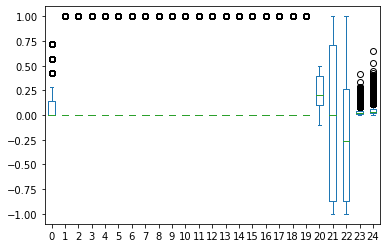

In [ ]:
X_processed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_processed.plot(kind='box');

In [ ]:
# Geo hashing

In [ ]:
import pygeohash as gh

In [ ]:
x0 = X_train.iloc[0,:]
(x0.pickup_latitude, x0.pickup_longitude)

(40.747753, -73.983116)

In [ ]:
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=3))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=4))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=5))

dr5
dr5r
dr5ru


In [ ]:
geohashes = pd.concat([
    X_train.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1),
    X_train.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1),
])

94


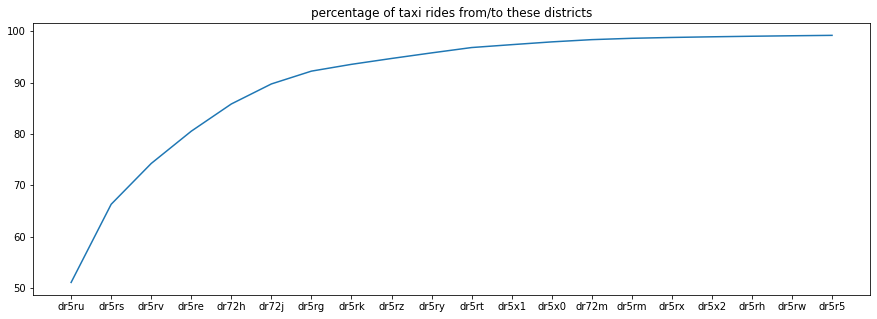

In [ ]:
print(len(geohashes.value_counts()))
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(geohashes.value_counts()[:20])/(2*len(X_train))*100)
plt.title("percentage of taxi rides from/to these districts");

In [ ]:
# taking 20 most relevant districts 
most_important_geohash_districts = np.array(geohashes.value_counts()[:20].index)
most_important_geohash_districts

array(['dr5ru', 'dr5rs', 'dr5rv', 'dr5re', 'dr72h', 'dr72j', 'dr5rg',
       'dr5rk', 'dr5rz', 'dr5ry', 'dr5rt', 'dr5x1', 'dr5x0', 'dr72m',
       'dr5rm', 'dr5rx', 'dr5x2', 'dr5rh', 'dr5rw', 'dr5r5'], dtype=object)

In [ ]:
# Let's hard-code below the 20 most frequent district geohash of precision 5,
# covering about 99% of all dropoff/pickup location.
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]

In [ ]:
def compute_geohash(X:pd.DataFrame, precision:int = 5) -> np.ndarray:
    """
    Add a geohash (ex: "dr5rx") of len "precision" = 5 by default
    corresponding to each (lon,lat) tuple, for pick-up, and drop-off
    """
    assert isinstance(X, pd.DataFrame)

    X["geohash_pickup"] = X.apply(lambda x: gh.encode(
        x.pickup_latitude, x.pickup_longitude, precision=precision),
                                    axis=1)
    X["geohash_dropoff"] = X.apply(lambda x: gh.encode(
        x.dropoff_latitude, x.dropoff_longitude, precision=precision),
                                    axis=1)
    return X[["geohash_pickup", "geohash_dropoff"]]

In [ ]:
geohash_categories = {
    0: most_important_geohash_districts,  # pickup district list
    1: most_important_geohash_districts  # dropoff district list
}

In [ ]:
geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(categories=geohash_categories,
                  handle_unknown="ignore",
                  sparse=False))
geohash_pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function compute_geohash at 0x7f46a0664c10>)),
                ('onehotencoder',
                 OneHotEncoder(categories={0: ['dr5ru', 'dr5rs', 'dr5rv',
                                               'dr72h', 'dr72j', 'dr5re',
                                               'dr5rk', 'dr5rz', 'dr5ry',
                                               'dr5rt', 'dr5rg', 'dr5x1',
                                               'dr5x0', 'dr72m', 'dr5rm',
                                               'dr5rx', 'dr5x2', 'dr5rw',
                                               'dr5rh', 'dr5x8'],
                                           1: ['dr5ru', 'dr5rs', 'dr5rv',
                                               'dr72h', 'dr72j', 'dr5re',
                                               'dr5rk', 'dr5rz', 'dr5ry',
                                               'dr5rt', 'dr5rg', 'dr5x1',
                                               'dr5x0', 'dr72m', 'dr5rm',
                                               'dr5rx', 'dr5x2', 'dr5rw',
                                               'dr5rh', 'dr5x8']},
                               handle_unknown='ignore', sparse=False))])

In [ ]:
# PASSENGER PIPE
p_min = 1
p_max = 8
passenger_pipe = FunctionTransformer(lambda p: (p - p_min) /
                                        (p_max - p_min))

# DISTANCE PIPE
dist_min = 0
dist_max = 100
distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min)/(dist_max - dist_min))
)

# TIME PIPE
year_min = 2009
year_max = 2019
time_categories = {
    0: np.arange(0, 7, 1),  # days of the week
    1: np.arange(1, 13, 1)  # months of the year
}
time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse=False,
            handle_unknown="ignore"), [2,3]), # correspond to columns ["day of week", "month"], not the others columns
        (FunctionTransformer(lambda year: (year-year_min)/(year_max-year_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
        )
    )

# GEOHASH PIPE
lonlat_features = [
    "pickup_latitude", "pickup_longitude", "dropoff_latitude",
    "dropoff_longitude"
]

# Below are the 20 most frequent district geohash of precision 5,
# covering about 99% of all dropoff/pickup location,
# according to prior analysis in a separate notebook
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]

geohash_categories = {
    0: most_important_geohash_districts,  # pickup district list
    1: most_important_geohash_districts  # dropoff district list
}

geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(categories=geohash_categories,
                    handle_unknown="ignore",
                    sparse=False))

# COMBINED PREPROCESSOR
final_preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
        ("geohash", geohash_pipe, lonlat_features),
    ],
    n_jobs=-1,
)

In [ ]:
final_preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x7f46a063d9d0>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x7f46a4b139d0>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformer...
                                                                                'dr5x0',
                                                                                'dr72m',
                                                                                'dr5rm',
                                                                                'dr5rx',
                                                                                'dr5x2',
                                                                                'dr5rw',
                                                                                'dr5rh',
                                                                                'dr5x8'],
                                                                            1: ['dr5ru',
                                                                                'dr5rs',
                                                                                'dr5rv',
                                                                                'dr72h',
                                                                                'dr72j',
                                                                                'dr5re',
                                                                                'dr5rk',
                                                                                'dr5rz',
                                                                                'dr5ry',
                                                                                'dr5rt',
                                                                                'dr5rg',
                                                                                'dr5x1',
                                                                                'dr5x0',
                                                                                'dr72m',
                                                                                'dr5rm',
                                                                                'dr5rx',
                                                                                'dr5x2',
                                                                                'dr5rw',
                                                                                'dr5rh',
                                                                                'dr5x8']},
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

In [ ]:
X_train_processed = final_preprocessor.fit_transform(X_train)

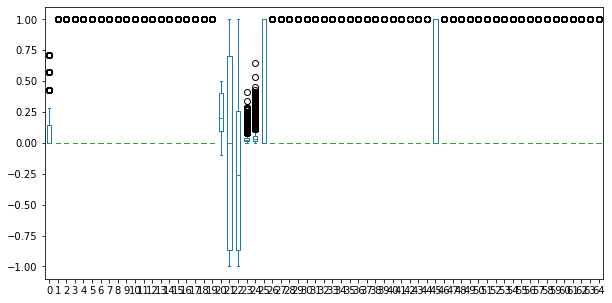

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(X_train_processed).plot(kind='box', ax=ax);

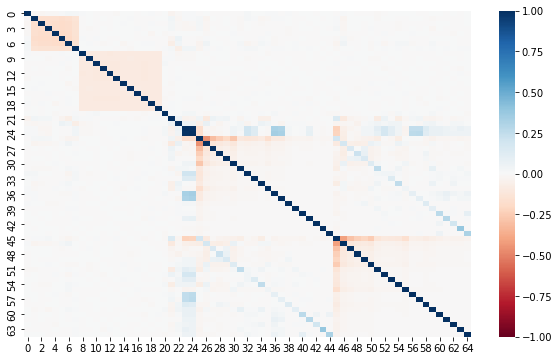

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(pd.DataFrame(X_train_processed).corr(), vmin=-1, cmap='RdBu');

In [ ]:
X_train_processed.dtype

dtype('float64')

In [ ]:
print(X_train_processed.nbytes / 1024**2, "MB")

33.80226135253906 MB


In [ ]:
# compress a bit the data
X_train_processed = X_train_processed.astype(np.float32)
print(X_train_processed.nbytes / 1024**2, "MB")

16.90113067626953 MB


In [ ]:
pd.DataFrame(X_train_processed)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.714286,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.285714,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.142857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68157,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68158,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68159,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68160,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1]:
# Model build 

In [ ]:
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def initialize_model(X: np.ndarray) -> Model:
    """
    Initialize the Neural Network with random weights
    """

    reg = regularizers.l1_l2(l2=0.01)

    model = Sequential()
    model.add(layers.BatchNormalization(input_shape=X.shape[1:]))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer=reg, input_shape=X.shape[1:]))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(50, activation="relu", kernel_regularizer=reg))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.BatchNormalization(momentum=0.99)) # use momentum=0 for to only use statistic of the last seen minibatch in inference mode ("short memory"). Use 1 to average statistics of all seen batch during training histories.
    
    model.add(layers.Dense(1, activation="linear"))

    print("✅ model initialized")

    return model

In [ ]:
model = initialize_model(X_train_processed)
model.summary()

✅ model initialized
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 65)               260       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               6600      
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 batch_normalization_2 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                    

2022-09-19 18:46:59.897972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-19 18:46:59.929700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-19 18:46:59.929748: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-19 18:46:59.931225: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [ ]:
learning_rate = 0.001
batch_size = 256

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

In [ ]:
es = EarlyStopping(monitor="val_loss",
                    patience=2,
                    restore_best_weights=True,
                    verbose=0)

history = model.fit(X_train_processed,
                    y_train,
                    validation_split=0.3,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks=[es],
                    verbose=1)

Epoch 1/100
187/187 [==============================] - 2s 5ms/step - loss: 163.6790 - mae: 10.5925 - val_loss: 221.4702 - val_mae: 12.0172
Epoch 2/100
187/187 [==============================] - 1s 4ms/step - loss: 107.1347 - mae: 8.9187 - val_loss: 136.0851 - val_mae: 9.2115
Epoch 3/100
187/187 [==============================] - 1s 4ms/step - loss: 69.7624 - mae: 6.8430 - val_loss: 63.1384 - val_mae: 5.6451
Epoch 4/100
187/187 [==============================] - 1s 4ms/step - loss: 41.8335 - mae: 4.5656 - val_loss: 36.5167 - val_mae: 3.4274
Epoch 5/100
187/187 [==============================] - 1s 4ms/step - loss: 26.8754 - mae: 2.7741 - val_loss: 25.4015 - val_mae: 2.3469
Epoch 6/100
187/187 [==============================] - 1s 4ms/step - loss: 21.8432 - mae: 2.1434 - val_loss: 22.2889 - val_mae: 2.0876
Epoch 7/100
187/187 [==============================] - 1s 4ms/step - loss: 20.4372 - mae: 2.0787 - val_loss: 22.1503 - val_mae: 2.1369
Epoch 8/100
187/187 [============================

In [ ]:
# Evaluating

X_test_processed = final_preprocessor.transform(X_test)

In [ ]:
y_pred = model.predict(X_test_processed)

In [ ]:
model.evaluate(X_test_processed, y_test)

913/913 [==============================] - 1s 1ms/step - loss: 19.4562 - mae: 2.0073


[19.456172943115234, 2.007301092147827]

(0.0, 60.0)

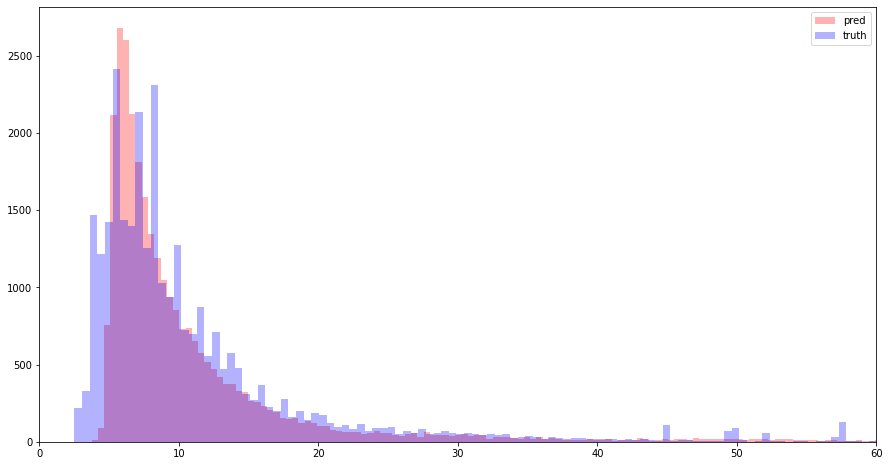

In [ ]:
plt.figure(figsize=(15,8))
import seaborn as sns
import matplotlib.pyplot as plt
plt.hist(y_pred, label='pred', color='r', bins=200, alpha=0.3)
plt.hist(y_test, label='truth', color='b', bins=200, alpha=0.3)
plt.legend()
plt.xlim((0,60))

In [ ]:
residuals = y_pred - y_test

In [ ]:
residuals.describe()

,fare_amount
count,29213.000000
mean,-0.164013
std,4.078877
min,-102.642921
25%,-1.106474
50%,0.208154
75%,1.295549
max,55.663818


(-20.0, 20.0)

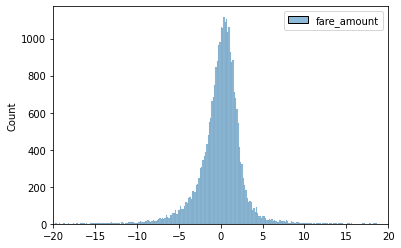

In [ ]:
residuals = y_pred - y_test
sns.histplot(residuals)
plt.xlim(xmin=-20, xmax=20)

In [ ]:
residuals.sort_values(by='fare_amount')

,fare_amount
85058,-102.642921
99508,-97.559044
37542,-90.574158
80171,-75.463226
2671,-73.688248
...,...
17380,45.185562
63043,50.655201
37108,50.720306
1486,51.497284


Text(0, 0.5, 'residuals')

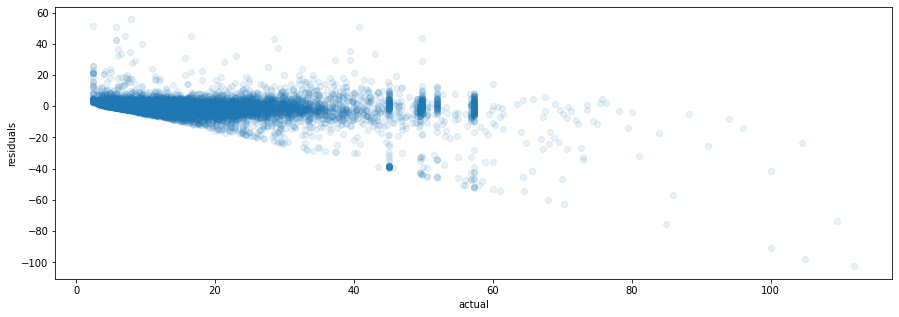

In [ ]:
# Residual vs. Actual scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_test,y=residuals, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

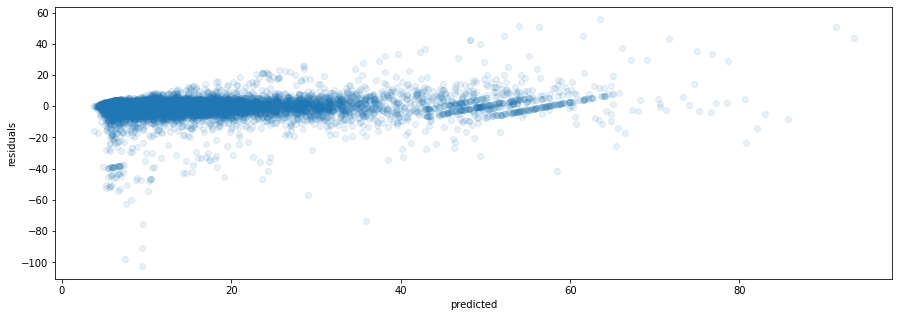

In [ ]:
# Residual vs. Predicted scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_pred,y=residuals, alpha=0.1)
plt.xlabel('predicted')
plt.ylabel('residuals')